In [133]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [91]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

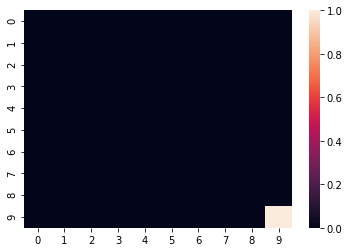

In [92]:
hm1 = sns.heatmap(Rfunc1)

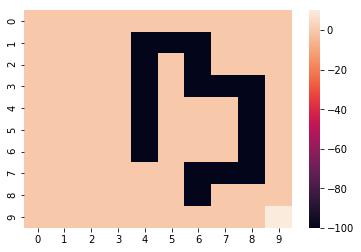

In [93]:
hm2 = sns.heatmap(Rfunc2)

In [94]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [95]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [96]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [97]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [98]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [99]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [100]:
from tabulate import tabulate

In [101]:
Vs1_2d = Vs1.reshape((height, width))
print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))

╒═══════════╤═══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0.0417957 │ 0.0628379 │ 0.089742 │ 0.123849 │ 0.167081 │ 0.221883 │ 0.291354 │ 0.37942  │ 0.490983 │ 0.609648 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.0628379 │ 0.0878701 │ 0.121557 │ 0.164514 │ 0.219246 │ 0.28899  │ 0.377871 │ 0.491061 │ 0.633219 │ 0.787354 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.089742  │ 0.121557  │ 0.16439  │ 0.219132 │ 0.288903 │ 0.377826 │ 0.491156 │ 0.63549  │ 0.817355 │ 1.0186   │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.123849  │ 0.164514  │ 0.219132 │ 0.2889   │ 0.377825 │ 0.491159 │ 0.635601 │ 0.81961  │ 1.05219  │ 1.31506  │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────

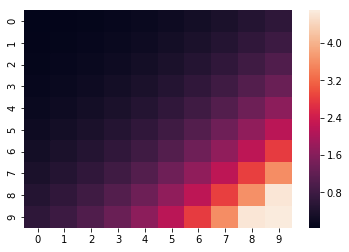

In [102]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [116]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    return [arrows[int(i)] for i in action]

In [117]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

In [118]:
optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
print(tabulate(optimalAction1_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [119]:
print(tabulate(path1))

-  -  -  -  -  -  -  -  -  -
↓  →  →  →  →  →  →  ↓  ↓  ↓
↓  →  →  →  →  →  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  →  ↓  ↓  ↓  ↓
↓  →  →  →  →  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
→  →  →  →  →  →  →  →  →  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


In [120]:
#problem6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

In [121]:
Vs2_2d = Vs2.reshape((height, width))
print(tabulate(Vs2_2d.T,  tablefmt='fancy_grid'))

╒══════════╤══════════╤══════════╤════════════╤══════════╤════════════╤═══════════╤══════════╤═══════════╤══════════╕
│ 0.648477 │ 0.794107 │ 0.825238 │  0.536246  │ -2.37043 │  -4.23382  │ -1.92053  │  1.13111 │  1.59436  │  2.03821 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 0.829852 │ 1.02124  │ 1.06603  │ -1.8679    │ -6.73822 │  -8.67375  │ -6.36979  │ -1.2948  │  1.92834  │  2.61047 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.06361  │ 1.31651  │ 1.45008  │ -1.62403   │ -6.74151 │ -13.9112   │ -9.64923  │ -5.51104 │ -0.131013 │  3.35906 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.36025  │ 1.6927   │ 1.94802  │ -1.23217   │ -6.32308 │  -7.97761  │ -7.93668  │ -9.42387 │ -1.91443  │  4.39063 │
├──────────┼──────────┼──────────┼────────────┼─────────

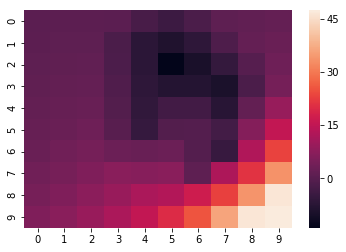

In [122]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [123]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

In [124]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
print(tabulate(optimalAction2_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 0 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [125]:
print(tabulate(path2))

-  -  -  -  -  -  -  -  -  -
↓  ↓  ↓  ←  ←  →  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↑  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↑  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↓  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ↓  ↓  ↓
→  →  →  ↓  ↓  ↓  ↓  ↓  ↓  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


In [142]:
#Question 11:
import numpy as np
from cvxopt import solvers
lamda_list = np.linspace(1,5,500)
trans_probs = tp
lamda = lamda_list[0]
print(optimalAction1)

[2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1.]


In [217]:
# def calculate_accuracy(oa, oe):
#     for s in range(0,100):
        
tp = np.zeros((100,4,100))

In [218]:
def calculate_LP_D(a, s, policy, gamma, tp):
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [219]:
n_states = 100

policy = optimalAction1
C = -np.hstack([np.zeros([100,100]), np.ones([100,100]),
                    -lamda*np.ones([100,100]), np.zeros([100,100])])
print(C.shape)

(100, 400)


In [220]:
A = {0,1,2,3}
transition_probability = np.transpose(tp, (1, 0, 2))
print(transition_probability.shape)
# LP_D1 = np.vstack([
#         -calculate_LP_D(a, s, policy, gamma, tp)
#         for s in range(100)
#         for a in All_actions - {policy[s]}
#     ])
gamma = 1.1
T_stack = np.vstack([
        -calculate_LP_D(a, s, policy, gamma, transition_probability)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])

print(T_stack.shape)
D_1 = np.hstack([T_stack,np.zeros((300,100)),np.zeros((300,100)),np.zeros((300,100))])
print(D_1.shape)


(4, 100, 100)
(300, 100)
(300, 400)


In [221]:
I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
print(I_stack1)
print(I_stack1.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(300, 100)


In [210]:
I_stack2 = np.ones((100,100))
print(I_stack2.shape)
print(I_stack2)
D_2 = np.hstack([I_stack2,np.zeros((100,100)),-I_stack2,np.zeros((100,100))])
D_3 = np.hstack([-I_stack2,np.zeros((100,100)),-I_stack2,np.zeros((100,100))])
D_4 = np.hstack([I_stack2,np.zeros((100,100)),np.zeros((100,100)),I_stack2])
D_5 = np.hstack([-I_stack2,np.zeros((100,100)),np.zeros((100,100)),-I_stack2])
D = np.vstack([D_1, D_2, D_3, D_4, D_5])
print(D.shape)

(100, 100)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(700, 400)


In [205]:
# zero_stack2 = np.zeros((n_states, n_states))
# print(zero_stack2)
# print(zero_stack2.shape)

In [204]:
# zero_stack1 = np.zeros((n_states*(4-1), n_states))
# print(zero_stack1)
# print(zero_stack1.shape)

In [216]:
Rmax = 1
# bounds = np.array([(None, None)]*2*n_states + [(-Rmax, Rmax)]*n_states)
# print(bounds)
# print(bounds.shape)
print(300, 2)

300 2


In [215]:
# D_bounds = np.hstack([
#         np.vstack([
#             -np.eye(n_states),
#             np.eye(n_states)]),
#         np.vstack([
#             np.zeros((n_states, n_states)),
#             np.zeros((n_states, n_states))]),
#         np.vstack([
#             np.zeros((n_states, n_states)),
#             np.zeros((n_states, n_states))])])

# print(D_bounds)
# print(D_bounds.shape)
print(200, 300)

200 300


In [214]:
# n_actions = 4
# b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
# b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
# b = np.vstack((b, b_bounds))
# print(b.shape)
print(1000, 1)

1000 1


In [213]:
# D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
# D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
# D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

# D = np.hstack([D_left, D_middle, D_right])
# D = np.vstack((D, D_bounds))
# print(D.shape)
print(1000,300)

1000 300


In [212]:
from cvxopt import matrix, solvers
print(D.shape)
A_ub = matrix(D)
b = np.zeros((700, 1))
b = matrix(b)
c = matrix(c)

results = solvers.lp(c, A_ub, b)
r = np.asarray(results["x"][:n_states], dtype=np.double)

return r.reshape((n_states,))

AttributeError: 'cvxopt.base.matrix' object has no attribute 'shape'